In [12]:
# 0. Setup
import os
from typing import List, Dict, Optional, Annotated, Sequence, TypedDict
from dataclasses import dataclass

from dotenv import load_dotenv
load_dotenv()

# Models / keys
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# LangChain / LangGraph core
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings

# Vector store + loaders + splitters
from langchain_community.document_loaders import TextLoader, WebBaseLoader, ArxivLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Tools
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper

# Graph orchestration
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

# Utils
import json
import uuid


In [13]:
# 1. Models and Utilities

# Primary chat LLM
llm = init_chat_model("openai:gpt-4o")

# Optionally a lighter-weight LLM for reflections/rewrite
rewrite_llm = init_chat_model("openai:gpt-4o-mini")  # or reuse llm

embeddings = OpenAIEmbeddings()

def chunk_docs(docs, chunk_size=500, chunk_overlap=50):
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_documents(docs)

def build_vector_retriever_from_text(file_path: str):
    docs = TextLoader(file_path, encoding="utf-8").load()
    chunks = chunk_docs(docs)
    vs = FAISS.from_documents(chunks, embeddings)
    return vs.as_retriever()

def build_vector_retriever_from_urls(urls: List[str]):
    docs = []
    for url in urls:
        try:
            docs.extend(WebBaseLoader(url).load())
        except Exception:
            pass
    chunks = chunk_docs(docs)
    vs = FAISS.from_documents(chunks, embeddings)
    return vs.as_retriever()

def format_docs(docs):
    return "\n\n".join(getattr(d, "page_content", str(d)) for d in docs)


In [30]:
# 2. Build local retrievers

# Local notes
local_retriever = build_vector_retriever_from_text("research_notes.txt")
internal_retriever = None  # Set this if you have internal docs


# Optional: Web resources (will fetch once and build local vector index)
seed_urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]

web_retriever = build_vector_retriever_from_urls(seed_urls)


In [15]:
# 3. External tools

wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

def wikipedia_search(query: str) -> str:
    try:
        return wiki_tool.run(query)
    except Exception:
        return ""

def arxiv_search(query: str, limit: int = 2) -> str:
    try:
        results = ArxivLoader(query).load()
        return "\n\n".join(doc.page_content[:1500] for doc in results[:limit]) or ""
    except Exception:
        return ""

# Simple YouTube transcript stub retriever (demo)
def youtube_stub_retriever():
    content = """
    This video explains how agentic AI systems rely on feedback loops, memory, and tool use.
    It compares them to traditional pipeline-based LLMs. Temporal reasoning and autonomous tasking are emphasized.
    """
    from langchain.schema import Document
    vs = FAISS.from_documents([Document(page_content=content, metadata={"source":"youtube"})], embeddings)
    return vs.as_retriever()

yt_retriever = youtube_stub_retriever()


In [32]:
@dataclass
class AgentConfig:
    max_iterations: int = 3
    require_reflection_pass: bool = True
    retrieval_per_subq: int = 4

class AgentState(TypedDict):
    question: str
    improved_question: str
    sub_questions: List[str]
    retrieved_local: List
    retrieved_internal: List
    retrieved_web: List
    wiki_context: str
    arxiv_context: str
    yt_docs: List
    draft_answer: str
    reflection: str
    final_answer: str
    attempts: int
    done: bool
    iteration_count: int

def initial_state(question: str) -> AgentState:
    return {
        "question": question,
        "improved_question": "",
        "sub_questions": [],
        "retrieved_local": [],
        "retrieved_internal": [],
        "retrieved_web": [],
        "wiki_context": "",
        "arxiv_context": "",
        "yt_docs": [],
        "draft_answer": "",
        "reflection": "",
        "final_answer": "",
        "attempts": 0,
        "done": False,
        "iteration_count": 0,
    }


In [33]:
# Node Functions
def rewrite_query_node(state: AgentState) -> AgentState:
    q = state["question"]
    prompt = f"""
You are a query rewriting expert. Improve the following question for retrieval:
Original: {q}

Return only the improved query.
"""
    resp = rewrite_llm.invoke(prompt).content.strip()
    state["improved_question"] = resp or q
    return state

In [34]:
def plan_decompose_node(state: AgentState) -> AgentState:
    q = state["improved_question"] or state["question"]
    prompt = f"""
Decompose the complex question into 2-4 focused sub-questions for retrieval.

Question: {q}

Return each sub-question as a separate line without numbering.
"""
    resp = llm.invoke(prompt).content.strip()
    subs = [line.strip("- ").strip() for line in resp.split("\n") if line.strip()]
    state["sub_questions"] = subs[:4] if subs else [q]
    return state

In [35]:
def react_retrieve_node(state: AgentState) -> AgentState:
    config = AgentConfig()  # Use default config
    subqs = state["sub_questions"] or [state["improved_question"] or state["question"]]
    all_local, all_internal, all_web, all_yt = [], [], [], []

    for s in subqs:
        # Local research notes
        try:
            all_local.extend(local_retriever.invoke(s)[:config.retrieval_per_subq])
        except Exception:
            pass

        # Internal docs (optional)
        if internal_retriever:
            try:
                all_internal.extend(internal_retriever.invoke(s)[:config.retrieval_per_subq])
            except Exception:
                pass

        # Seeded web pages vectorized
        try:
            all_web.extend(web_retriever.invoke(s)[:config.retrieval_per_subq])
        except Exception:
            pass

        # YouTube stub
        try:
            all_yt.extend(yt_retriever.invoke(s)[:1])
        except Exception:
            pass

    state["retrieved_local"] = all_local
    state["retrieved_internal"] = all_internal
    state["retrieved_web"] = all_web
    state["yt_docs"] = all_yt

    # Wikipedia & ArXiv once on improved question
    big_q = state["improved_question"] or state["question"]
    state["wiki_context"] = wikipedia_search(big_q)
    state["arxiv_context"] = arxiv_search(big_q)

    return state

In [36]:
def retrieval_self_check_node(state: AgentState) -> AgentState:
    # Evaluate if retrieval seems sufficient
    q = state["improved_question"] or state["question"]
    bundle = "\n\n".join([
        "LOCAL:\n" + format_docs(state["retrieved_local"][:3]),
        "INTERNAL:\n" + format_docs(state["retrieved_internal"][:3]),
        "WEB:\n" + format_docs(state["retrieved_web"][:3]),
        "WIKI:\n" + (state["wiki_context"][:1500] or ""),
        "ARXIV:\n" + (state["arxiv_context"][:1500] or ""),
        "YOUTUBE:\n" + format_docs(state["yt_docs"][:1]),
    ])

    prompt = f"""
You are checking if the current retrieved context is sufficient to answer the question.

Question: {q}

Context snapshot:
{bundle}

Return one of:
- SUFFICIENT
- INSUFFICIENT + a single refined query that would retrieve more relevant context.
"""
    resp = llm.invoke(prompt).content.strip()
    lower = resp.lower()
    if "insufficient" in lower:
        refined = resp.split("+", 1)[-1].strip() if "+" in resp else ""
        if refined and refined != q:
            state["improved_question"] = refined
    return state


In [37]:
def draft_answer_node(state: AgentState) -> AgentState:
    q = state["improved_question"] or state["question"]
    
    # Combine all retrieved context
    all_context = []
    
    if state["retrieved_local"]:
        all_context.append("LOCAL RESEARCH NOTES:\n" + format_docs(state["retrieved_local"][:5]))
    
    if state["retrieved_internal"]:
        all_context.append("INTERNAL DOCS:\n" + format_docs(state["retrieved_internal"][:5]))
    
    if state["retrieved_web"]:
        all_context.append("WEB SOURCES:\n" + format_docs(state["retrieved_web"][:5]))
    
    if state["wiki_context"]:
        all_context.append("WIKIPEDIA:\n" + state["wiki_context"][:2000])
    
    if state["arxiv_context"]:
        all_context.append("ARXIV PAPERS:\n" + state["arxiv_context"][:2000])
    
    if state["yt_docs"]:
        all_context.append("VIDEO CONTENT:\n" + format_docs(state["yt_docs"][:2]))
    
    context_str = "\n\n---\n\n".join(all_context)
    
    prompt = f"""
You are an expert assistant. Answer the following question using the provided context.
Be comprehensive, accurate, and well-structured. Cite relevant sources when possible.

Question: {q}

Context:
{context_str}

Provide a detailed answer:
"""
    
    resp = llm.invoke(prompt).content.strip()
    state["draft_answer"] = resp
    return state


In [38]:
def reflect_and_verify_node(state: AgentState) -> AgentState:
    q = state["improved_question"] or state["question"]
    ans = state["draft_answer"]
    prompt = f"""
Reflect critically on the following answer for completeness, clarity, and correctness.

Question: {q}

Answer:
{ans}

Respond exactly in this format:
Reflection: YES or NO
Rationale: <2-4 bullet points>
If NO, include a one-line FixHint: <what specific retrieval or detail to add or adjust>.
"""
    resp = rewrite_llm.invoke(prompt).content.strip()
    state["reflection"] = resp
    return state

In [39]:
def finalize_or_retry_node(state: AgentState) -> AgentState:
    config = AgentConfig()  # Use default config
    state["attempts"] += 1
    state["iteration_count"] += 1
    
    ref = state["reflection"].lower()
    if ("reflection: yes" in ref) or (not config.require_reflection_pass):
        state["final_answer"] = state["draft_answer"]
        state["done"] = True
        return state

    # If NO and we have remaining iterations
    if state["iteration_count"] < config.max_iterations:
        # Extract fix hint
        fix_hint = ""
        if "fixhint:" in ref:
            try:
                fix_hint = state["reflection"].split("FixHint:", 1)[-1].strip()
            except:
                fix_hint = ""

        # Combine hint with current improved question
        new_q = (state["improved_question"] or state["question"])
        if fix_hint and fix_hint not in new_q:
            new_q = f"{new_q}. {fix_hint}"
        state["improved_question"] = new_q
        return state

    # If out of attempts, accept draft as final
    state["final_answer"] = state["draft_answer"]
    state["done"] = True
    return state

In [40]:
def should_continue(state: AgentState) -> str:
    if state["done"]:
        return "end"
    else:
        return "continue"

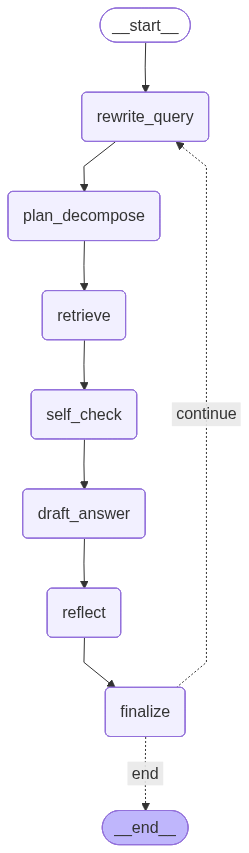

In [41]:
def create_autonomous_rag_graph():
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("rewrite_query", rewrite_query_node)
    workflow.add_node("plan_decompose", plan_decompose_node)
    workflow.add_node("retrieve", react_retrieve_node)
    workflow.add_node("self_check", retrieval_self_check_node)
    workflow.add_node("draft_answer", draft_answer_node)
    workflow.add_node("reflect", reflect_and_verify_node)
    workflow.add_node("finalize", finalize_or_retry_node)
    
    # Add edges
    workflow.add_edge(START, "rewrite_query")
    workflow.add_edge("rewrite_query", "plan_decompose")
    workflow.add_edge("plan_decompose", "retrieve")
    workflow.add_edge("retrieve", "self_check")
    workflow.add_edge("self_check", "draft_answer")
    workflow.add_edge("draft_answer", "reflect")
    workflow.add_edge("reflect", "finalize")
    
    # Add conditional edge for looping
    workflow.add_conditional_edges(
        "finalize",
        should_continue,
        {
            "continue": "rewrite_query",  # Loop back for refinement
            "end": END
        }
    )
    
    return workflow.compile()

# Create and visualize the graph
graph = create_autonomous_rag_graph()
graph

In [42]:
def visualize_graph():
    try:
        # Try to display the graph using mermaid
        print("Graph structure:")
        print("START -> rewrite_query -> plan_decompose -> retrieve -> self_check -> draft_answer -> reflect -> finalize")
        print("finalize -> (conditional) -> rewrite_query (if continue) OR END (if done)")
        
        # If you have graphviz installed, you can also use:
        # graph.get_graph().draw_mermaid()
        return graph.get_graph()
    except Exception as e:
        print(f"Visualization error: {e}")
        return None

In [43]:
def run_autonomous_rag(question: str) -> Dict:
    state = initial_state(question)
    
    # Run the graph
    result = graph.invoke(state)
    
    return {
        "question": question,
        "improved_question": result["improved_question"],
        "sub_questions": result["sub_questions"],
        "attempts": result["attempts"],
        "iterations": result["iteration_count"],
        "reflection": result["reflection"],
        "final_answer": result["final_answer"],
    }

In [44]:
# 7. Example Runs

examples = [
    "Explain how agent loops work and outline how an agentic RAG system should combine planning, retrieval, and self-reflection.",
    "What additional experiments should be included when evaluating Transformer variants for production deployment?",
]

for q in examples:
    result = run_autonomous_rag(q)
        
    print(f"Question: {result['question']}")
    print(f"Improved: {result['improved_question']}")
    print(f"Sub-questions: {result['sub_questions']}")
    print(f"Attempts: {result['attempts']}")
    print(f"Iterations: {result['iterations']}")
    print(f"Reflection:\n{result['reflection']}")
    print(f"\nFINAL ANSWER:\n{result['final_answer']}")


Question: Explain how agent loops work and outline how an agentic RAG system should combine planning, retrieval, and self-reflection.
Improved: Discuss the functionality of agent loops and describe the integration of planning, retrieval, and self-reflection within an agentic RAG system.
Sub-questions: ['What are agent loops and how do they function within a system?', 'How is planning integrated into an agentic RAG (Retrieve, Augment, Generate) system?', 'How does retrieval work within an agentic RAG system?', 'What role does self-reflection play in the functionality of an agentic RAG system?']
Attempts: 1
Iterations: 1
Reflection:
Reflection: YES  
Rationale:  
- The answer provides a comprehensive overview of agent loops and the integration of key components in an agentic RAG system, addressing the functionalities of feedback mechanisms, memory, and tool use effectively.  
- It clearly explains how planning, retrieval, and self-reflection interrelate within the context of a RAG system